<a href="https://colab.research.google.com/github/leonardochd/Prevendo-valores-acoes-regressao-linear/blob/main/Prevendo_pre%C3%A7o_das_a%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas-datareader

!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


#Criando o modelo para prever os valores das ações

####Importando as bibliotecas

In [61]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,8)

In [62]:
stock = input("Entre a sigla do nome da ação que você quer que seja treinado (exemplo: \'mglu3.sa\' para ações da Magalu): ")


Entre a sigla do nome da ação que você quer que seja treinado (exemplo: 'mglu3.sa' para ações da Magalu): mglu3.sa


####Importando o DataFrame

In [63]:
data_inicio = pd.to_datetime(['2020-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp
data_fim = pd.to_datetime(['2023-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + str(stock) + '?period1=' + str(data_inicio) + '&period2=' + str(data_fim) + '&interval=1d&events=history'
df = pd.read_csv(url)

# df.head()

<ipython-input-63-10129e9025fc>:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data_inicio = pd.to_datetime(['2020-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp
<ipython-input-63-10129e9025fc>:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  data_fim = pd.to_datetime(['2023-01-01']).astype(int)[0]//10**9 # convertendo para unix timestamp


In [64]:
# Criando novos campos de medias móveis com o intervalo de 7 e 21 dias de fechamento
df['mm7'] = df['Adj Close'].rolling(7).mean()
df['mm21d'] = df['Adj Close'].rolling(21).mean()

In [65]:

df['Adj Close'] = df['Adj Close'].shift(-1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
0,2020-01-02,12.075,12.3325,11.9275,12.3325,11.922435,29600800,NaN,NaN
1,2020-01-03,12.125,12.3325,12.0750,12.2225,11.932189,26737600,NaN,NaN
2,2020-01-06,12.100,12.3275,11.9500,12.2325,11.898047,27359200,NaN,NaN
3,2020-01-07,12.235,12.3000,12.1250,12.1975,12.263843,26818800,NaN,NaN
4,2020-01-08,12.155,12.5875,12.1250,12.5725,12.700356,40007200,NaN,NaN


Apagando os dados nulos para que o modelo não leia os dados NaN

In [66]:
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
20,2020-01-30,14.0925,14.1750,13.7550,14.1250,13.607525,44303600,13.691135,13.060808
21,2020-01-31,13.9100,14.2875,13.8000,13.9500,13.785543,38781200,13.694968,13.135941
22,2020-02-03,14.1200,14.2375,13.9150,14.1325,14.061108,24566000,13.693225,13.224661
23,2020-02-04,14.4000,14.6675,14.2825,14.4150,13.973319,32872800,13.745830,13.326038
24,2020-02-05,14.6250,14.7100,14.2575,14.3250,13.614841,34484400,13.867761,13.424860
...,...,...,...,...,...,...,...,...,...
739,2022-12-22,2.6400,2.6600,2.5100,2.6000,2.680000,184677300,2.605714,2.955714
740,2022-12-23,2.6200,2.8300,2.6200,2.6800,2.660000,195172100,2.612857,2.911905
741,2022-12-26,2.7100,2.7300,2.5600,2.6600,2.520000,73999000,2.621429,2.875714
742,2022-12-27,2.6700,2.7100,2.5000,2.5200,2.690000,147780600,2.642857,2.837619


In [67]:
# Verificando a quantidade de linhas
qtd_linhas = len(df)

qtd_linhas_treino = round(0.5 * qtd_linhas)
qtd_linhas_teste = 300
qtd_linhas_validacao = qtd_linhas - 1

info = (
    f"linhas treino = 0:{qtd_linhas_treino} | "
    f"linhas teste = {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste - 1} | "
    f"linhas validação = {qtd_linhas_validacao}"
)

info

'linhas treino = 0:362 | linhas teste = 362:661 | linhas validação = 723'

In [68]:
df["data_pregao"] = df['Date']
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d,data_pregao
20,2020-01-30,14.0925,14.1750,13.7550,14.1250,13.607525,44303600,13.691135,13.060808,2020-01-30
21,2020-01-31,13.9100,14.2875,13.8000,13.9500,13.785543,38781200,13.694968,13.135941,2020-01-31
22,2020-02-03,14.1200,14.2375,13.9150,14.1325,14.061108,24566000,13.693225,13.224661,2020-02-03
23,2020-02-04,14.4000,14.6675,14.2825,14.4150,13.973319,32872800,13.745830,13.326038,2020-02-04
24,2020-02-05,14.6250,14.7100,14.2575,14.3250,13.614841,34484400,13.867761,13.424860,2020-02-05
...,...,...,...,...,...,...,...,...,...,...
739,2022-12-22,2.6400,2.6600,2.5100,2.6000,2.680000,184677300,2.605714,2.955714,2022-12-22
740,2022-12-23,2.6200,2.8300,2.6200,2.6800,2.660000,195172100,2.612857,2.911905,2022-12-23
741,2022-12-26,2.7100,2.7300,2.5600,2.6600,2.520000,73999000,2.621429,2.875714,2022-12-26
742,2022-12-27,2.6700,2.7100,2.5000,2.5200,2.690000,147780600,2.642857,2.837619,2022-12-27


 Apagando a coluna 'Date' e reindexando o DataFrame

In [69]:
df = df.drop('Date', axis=1)
df = df.reset_index(drop=True)

df

,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d,data_pregao
0,14.0925,14.1750,13.7550,14.1250,13.607525,44303600,13.691135,13.060808,2020-01-30
1,13.9100,14.2875,13.8000,13.9500,13.785543,38781200,13.694968,13.135941,2020-01-31
2,14.1200,14.2375,13.9150,14.1325,14.061108,24566000,13.693225,13.224661,2020-02-03
3,14.4000,14.6675,14.2825,14.4150,13.973319,32872800,13.745830,13.326038,2020-02-04
4,14.6250,14.7100,14.2575,14.3250,13.614841,34484400,13.867761,13.424860,2020-02-05
...,...,...,...,...,...,...,...,...,...
719,2.6400,2.6600,2.5100,2.6000,2.680000,184677300,2.605714,2.955714,2022-12-22
720,2.6200,2.8300,2.6200,2.6800,2.660000,195172100,2.612857,2.911905,2022-12-23
721,2.7100,2.7300,2.5600,2.6600,2.520000,73999000,2.621429,2.875714,2022-12-26
722,2.6700,2.7100,2.5000,2.5200,2.690000,147780600,2.642857,2.837619,2022-12-27


In [70]:
df_completo = df

features = df.drop(['Close', 'Adj Close', 'data_pregao'], 1)
labels = df['Adj Close']

<ipython-input-70-260aa15c80d0>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features = df.drop(['Close', 'Adj Close', 'data_pregao'], 1)


####Importando as bibliotecas

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [72]:
features_list = ('Open','High','Low','Volume','mm7','mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'Low': 660.9646090775381, 'Volume': 629.2440741483928, 'High': 500.9386103493225, 'mm21d': 480.6901849959776, 'mm7': 2.6152846522163653}


In [73]:
#Separa os dados de treino teste e validação
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

362 362
299 299


In [74]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [75]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd = r2_score(y_test, pred)
MAE = mean_absolute_error(y_test, pred)


# f'Coeficiente de determinação:{cd * 100:.2f}'
print("Coeficiente de determinação: " + str(cd*100) + "%")
print("Erro médio absoluto: " + str(MAE))

Coeficiente de determinação: 99.43552766890024%
Erro médio absoluto: 0.30167608924159084


In [76]:
valor_novo = features.tail(58)
valor_novo

,Open,High,Low,Volume,mm7,mm21d
666,5.11,5.27,4.99,164826200,4.594286,4.527143
667,5.18,5.40,5.10,175361700,4.764286,4.592381
668,5.34,5.41,5.23,152240200,4.904286,4.640952
669,5.34,5.46,5.19,133736800,5.085714,4.685714
670,5.32,5.44,5.12,156212100,5.184286,4.703810
671,5.17,5.18,4.81,180292000,5.185714,4.714286
672,4.96,4.99,4.33,256264000,5.082857,4.709524
673,4.47,4.68,4.35,182160100,4.975714,4.710952
674,4.49,4.53,4.21,185606300,4.825714,4.704286
675,4.31,4.31,4.07,179107600,4.665714,4.686667


####Executando a previsão

In [77]:
previsao=scaler.transform(valor_novo)
pred=lr.predict(previsao)

pred

array([4.94280516, 5.10813578, 5.14255552, 5.19877894, 5.14330851,
       4.77730758, 4.31069845, 4.50763274, 4.21982786, 4.0429658 ,
       3.83731452, 3.9822562 , 3.94842768, 4.21719594, 3.79522988,
       4.08158735, 4.16464884, 4.26930343, 4.27329174, 4.60541311,
       4.60306906, 4.50045465, 4.61585821, 4.39474471, 3.94860037,
       3.29587016, 3.55026266, 3.27011265, 3.16610559, 3.02339866,
       3.22802029, 3.10070617, 3.15275421, 3.45926509, 3.16882626,
       3.28168304, 3.13437911, 3.19582246, 2.98852193, 3.10593876,
       2.99470656, 3.03832079, 2.82016918, 2.78672517, 2.74556106,
       2.73999699, 2.69035521, 2.38830619, 2.54563018, 2.2739725 ,
       2.42174423, 2.65847251, 2.39784574, 2.39526122, 2.63492752,
       2.52638354, 2.44350955, 2.54884543])

In [78]:
data_pregao_full=df_completo['data_pregao']
data_pregao=data_pregao_full.tail(58)

res_full=df_completo['Adj Close']
res=res_full.tail(58)

df=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred})


df.set_index('data_pregao', inplace=True)

df.head()

,real,previsao
data_pregao,,
2022-10-05,5.37,4.942805
2022-10-06,5.31,5.108136
2022-10-07,5.32,5.142556
2022-10-10,5.17,5.198779
2022-10-11,4.92,5.143309


####Plotando o gráfico

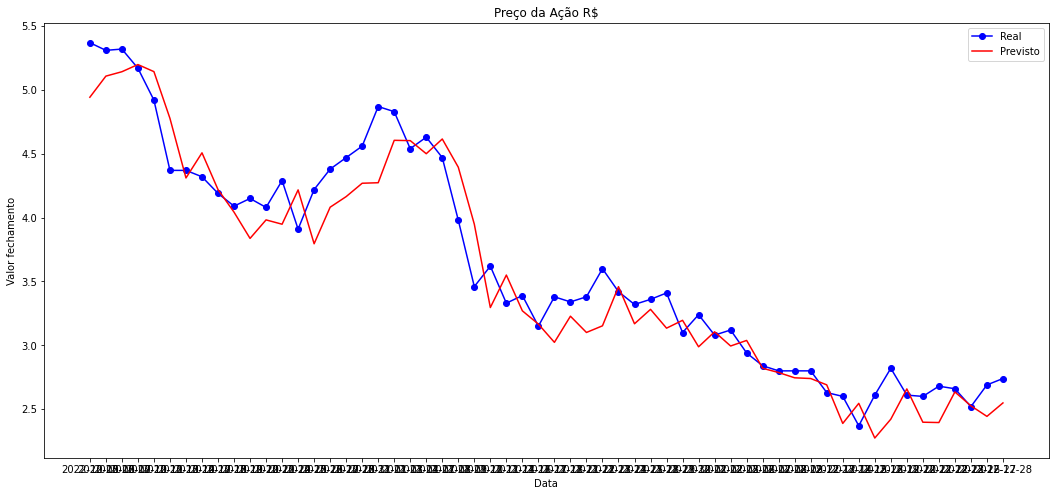

In [79]:
plt.title("Preço da Ação R$")
plt.plot(df["real"],label = "Real", color = "blue", marker = 'o')
plt.plot(df["previsao"],label = "Previsto", color = "red")
plt.xlabel("Data")
# plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
plt.ylabel("Valor fechamento")
plt.legend()

In [80]:
for index, row in df.iterrows():
    df.loc[index,'diferenca'] = (df.loc[index,'real'] - df.loc[index,'previsao']);


df.head()

,real,previsao,diferenca
data_pregao,,,
2022-10-05,5.37,4.942805,0.427195
2022-10-06,5.31,5.108136,0.201864
2022-10-07,5.32,5.142556,0.177444
2022-10-10,5.17,5.198779,-0.028779
2022-10-11,4.92,5.143309,-0.223309
